# SimPy: Treatment Centre

```{admonition} Running the model
**This version of the simulation model is in this notebook and can be executed online. You do not need to install anything on your computer.** Move you mourse cursor over the rocket ship icon above and choose one of the two options: Binder (launches an external remote instance of Jupyter-Lab) or Thebe (code cells are excutable within the book).
```
> See [detailed instructions](./03_instr.md) for more help.
---

## 1. Imports

The model is provided with a conda virtual environment `stars_treat_sim`.  Details are available in the [Github repo](https://github.com/pythonhealthdatascience/stars-treat-sim).

In [1]:
import simpy
simpy.__version__

'4.1.1'

In [2]:
import numpy as np
import pandas as pd
import itertools
import math
import matplotlib.pyplot as plt
import fileinput

from rich.console import Console
from rich.progress import track
#console = Console()

## 2. Constants and defaults for modelling **as-is**

### 2.1 Distribution parameters

In [3]:
# sign-in/triage parameters
DEFAULT_TRIAGE_MEAN = 3.0

# registration parameters
DEFAULT_REG_MEAN = 5.0
DEFAULT_REG_VAR= 2.0

# examination parameters
DEFAULT_EXAM_MEAN = 16.0
DEFAULT_EXAM_VAR = 3.0
DEFAULT_EXAM_MIN = 0.5

# trauma/stabilisation
DEFAULT_TRAUMA_MEAN = 90.0

# Trauma treatment
DEFAULT_TRAUMA_TREAT_MEAN = 30.0
DEFAULT_TRAUMA_TREAT_VAR = 4.0

# Non trauma treatment
DEFAULT_NON_TRAUMA_TREAT_MEAN = 13.3
DEFAULT_NON_TRAUMA_TREAT_VAR = 2.0

# prob patient requires treatment given trauma
DEFAULT_NON_TRAUMA_TREAT_P = 0.60

# proportion of patients triaged as trauma
DEFAULT_PROB_TRAUMA = 0.12

### 2.2 Time dependent arrival rates data

The data for arrival rates varies between clinic opening at 6am and closure at 12am.

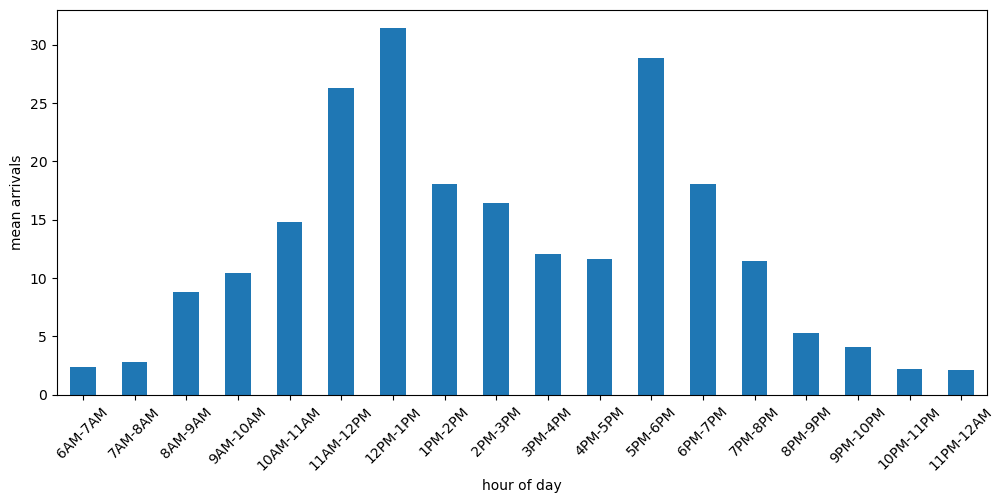

In [4]:
# data are held in the Github repo and loaded from there.
NSPP_PATH = 'https://raw.githubusercontent.com/TomMonks/' \
 + 'open-science-for-sim/main/src/notebooks/01_foss_sim/data/ed_arrivals.csv'

# visualise
ax = pd.read_csv(NSPP_PATH).plot(y='arrival_rate', x='period', rot=45,
                                 kind='bar',figsize=(12,5), legend=False)
ax.set_xlabel('hour of day')
ax.set_ylabel('mean arrivals');

### 2.3 Resource counts

> Inter count variables representing the number of resources at each activity in the processes.

In [5]:
DEFAULT_N_TRIAGE = 1
DEFAULT_N_REG = 1
DEFAULT_N_EXAM = 3
DEFAULT_N_TRAUMA = 2

# Non-trauma cubicles
DEFAULT_N_CUBICLES_1 = 1

# trauma pathway cubicles
DEFAULT_N_CUBICLES_2 = 1

### 2.4 Simulation model run settings

In [26]:
# default random number SET
DEFAULT_RNG_SET = None
N_STREAMS = 20

# default results collection period
DEFAULT_RESULTS_COLLECTION_PERIOD = 60 * 19

# number of replications.
DEFAULT_N_REPS = 5

## set to True to show a trace of the simulation model (best used in single run mode)
DEBUG = False

# provide a list of integers that represent patient IDs.  Only these patients will be tracked
TRACKED = None

## 3. Trace functionality 

Rather than using the `print` built in function to output a simulated trace it is desirable to control the if trace messages are shown or not shown.  The `SimulatedTrace` class is partly based on R's `simmer` functionality for output.  A user sets a `trace_level` threshold when creating an instance of the class.  The class is callable like a function and replaces the print built in e.g

```python
trace = SimulatedTrace()
trace("hello world")
```

It is then trivial to suppress messages to a user

```python
trace = SimulatedTrace(trace_level=2)

# this will not be printed as log_level is 0 by default
trace("hello world")

# this will NOT be printed in this experiment as log_level is less than 2
trace("level 1 message", trace_level=1)

# this will be printed!
trace("level 2 message", trace_level=2)
```


In [7]:
class SimulatedTrace:
    '''
    Utility class for printing a trace as the
    simulation model executes.
    
    Implemented using the Rich library
    to allow for coloured text.
    '''
    def __init__(self, trace_level=0):
        '''Simulated Trace
        Log events as they happen.

        Params:
        -------
        
        env: simpy.Environment
            The simpy environment. Used for printing out
            time.
            
        log_level: int, optional (default=0)
            Minimum log level of a print statement
            in order for it to be logged.
        '''
        self.trace_level = trace_level
        
    def __call__(self, msg, trace_level=0):
        '''Override callable.
        This makes objects behave like functions.
        decorates the print function. conditional
        logic to print output or not.
        
        Params:
        ------
        msg: str
            string to print to screen.
        
        trace_level: int, optional (default=0)
            minimum trace level in order for the message
            to display
        
        '''
        if (trace_level >= self.trace_level):
            console.print(msg)

In [8]:
def traceable(debug=False, 
              name=None, 
              name_colour="bold blue", 
              time_colour='bold blue', 
              message_colour='black',
              tracked=None):
    def decorator(cls):   
        class TracedProcess(cls):
            def __init__(self, *args, **kwargs):
                super().__init__(*args, **kwargs)
                self.debug = debug
                self.name = name
                self.name_colour = name_colour
                self.time_colour = time_colour
                self.message_colour = message_colour
                self.tracked = tracked
        
            def trace(self, time, msg=None, process_id=None):
                if self.debug:
                    
                    if tracked is None or process_id in self.tracked:
                    
                        out = f'[{self.time_colour}][{time:.3f}]:[/{self.time_colour}]'
                        if self.name is not None and process_id is not None:
                            out += f'[{name_colour}]<{name} {process_id}>: [/{name_colour}]'

                        out += f'[{message_colour}]{msg}[/{message_colour}]'

                        console.print(out)
                    
        return TracedProcess
    return decorator

In [9]:
from abc import ABC, abstractmethod

class Traceable(ABC):
    '''Provide basic trace functionality to subclass
    
    Abstract base class Traceable
    
    Subclasses must call 
    
    super().__init__(debug=True) in their __init__() method to 
    initialise trace.
    
    This adds 
    '''
    def __init__(self, debug=False):
        self.debug = debug
        self.config = self._default_config()
        self.console = Console()
    
    def _default_config(self):
        config = {
            "name":None, 
            "name_colour":"bold blue", 
            "time_colour":'bold blue', 
            "time_dp":2,
            "message_colour":'black',
            "tracked":None
        }
        return config
        
    
    def _trace_config(self):
        config = {
            "name":None, 
            "name_colour":"bold blue", 
            "time_colour":'bold blue', 
            "time_dp":2,
            "message_colour":'black',
            "tracked":None
        }
        return config
    
    
    def trace(self, time, msg=None, process_id=None):
        '''
        Display a trace of an event
        '''
        
        if not hasattr(self, 'config'):
            raise AttributeError("Your trace has not been initialised. Call super__init__(debug=True) in class initialiser"
                                 "or omit debug for default of no trace.")
        
        # if in debug mode
        if self.debug:
            
            # check for override to default configs
            process_config = self._trace_config()
            self.config.update(process_config)
            
            # conditional logic to limit tracking to specific processes/entities
            if self.config['tracked'] is None or process_id in self.config['tracked']:

                # display and format time stamp
                out = f"[{self.config['time_colour']}][{time:.{self.config['time_dp']}f}]:[/{self.config['time_colour']}]"
                
                # if provided display and format a process ID 
                if self.config['name'] is not None and process_id is not None:
                    out += f"[{self.config['name_colour']}]<{self.config['name']} {process_id}>: [/{self.config['name_colour']}]"

                # format traced event message
                out += f"[{self.config['message_colour']}]{msg}[/{self.config['message_colour']}]"

                # print to rich console
                self.console.print(out)
        

## 4. Distribution classes

To help with controlling sampling `numpy` distributions are packaged up into classes that allow easy control of random numbers.

**Distributions included:**
* Exponential
* Log Normal
* Bernoulli
* Normal
* Uniform

In [10]:
class Exponential:
    '''
    Convenience class for the exponential distribution.
    packages up distribution parameters, seed and random generator.
    '''
    def __init__(self, mean, random_seed=None):
        '''
        Constructor
        
        Params:
        ------
        mean: float
            The mean of the exponential distribution
        
        random_seed: int, optional (default=None)
            A random seed to reproduce samples.  If set to none then a unique
            sample is created.
        '''
        self.rng = np.random.default_rng(seed=random_seed)
        self.mean = mean
        
    def sample(self, size=None):
        '''
        Generate a sample from the exponential distribution
        
        Params:
        -------
        size: int, optional (default=None)
            the number of samples to return.  If size=None then a single
            sample is returned.
        '''
        return self.rng.exponential(self.mean, size=size)

    
class Bernoulli:
    '''
    Convenience class for the Bernoulli distribution.
    packages up distribution parameters, seed and random generator.
    '''
    def __init__(self, p, random_seed=None):
        '''
        Constructor
        
        Params:
        ------
        p: float
            probability of drawing a 1
        
        random_seed: int, optional (default=None)
            A random seed to reproduce samples.  If set to none then a unique
            sample is created.
        '''
        self.rng = np.random.default_rng(seed=random_seed)
        self.p = p
        
    def sample(self, size=None):
        '''
        Generate a sample from the exponential distribution
        
        Params:
        -------
        size: int, optional (default=None)
            the number of samples to return.  If size=None then a single
            sample is returned.
        '''
        return self.rng.binomial(n=1, p=self.p, size=size)

class Lognormal:
    """
    Encapsulates a lognormal distirbution
    """
    def __init__(self, mean, stdev, random_seed=None):
        """
        Params:
        -------
        mean: float
            mean of the lognormal distribution
            
        stdev: float
            standard dev of the lognormal distribution
            
        random_seed: int, optional (default=None)
            Random seed to control sampling
        """
        self.rng = np.random.default_rng(seed=random_seed)
        mu, sigma = self.normal_moments_from_lognormal(mean, stdev**2)
        self.mu = mu
        self.sigma = sigma
        
    def normal_moments_from_lognormal(self, m, v):
        '''
        Returns mu and sigma of normal distribution
        underlying a lognormal with mean m and variance v
        source: https://blogs.sas.com/content/iml/2014/06/04/simulate-lognormal
        -data-with-specified-mean-and-variance.html

        Params:
        -------
        m: float
            mean of lognormal distribution
        v: float
            variance of lognormal distribution
                
        Returns:
        -------
        (float, float)
        '''
        phi = math.sqrt(v + m**2)
        mu = math.log(m**2/phi)
        sigma = math.sqrt(math.log(phi**2/m**2))
        return mu, sigma
        
    def sample(self):
        """
        Sample from the normal distribution
        """
        return self.rng.lognormal(self.mu, self.sigma)

In [11]:
class Normal:
    '''
    Convenience class for the normal distribution.
    packages up distribution parameters, seed and random generator.

    Use the minimum parameter to truncate the distribution
    '''
    def __init__(self, mean, sigma, minimum=None, random_seed=None):
        '''
        Constructor
        
        Params:
        ------
        mean: float
            The mean of the normal distribution
            
        sigma: float
            The stdev of the normal distribution
            
        minimum: float, optional (default=None)
            Used to truncate the distribution (e.g. to 0.0 or 0.5)
        
        random_seed: int, optional (default=None)
            A random seed to reproduce samples.  If set to none then a unique
            sample is created.
        '''
        self.rng = np.random.default_rng(seed=random_seed)
        self.mean = mean
        self.sigma = sigma
        self.minimum = minimum
        
    def sample(self, size=None):
        '''
        Generate a sample from the normal distribution
        
        Params:
        -------
        size: int, optional (default=None)
            the number of samples to return.  If size=None then a single
            sample is returned.
        '''
        samples = self.rng.normal(self.mean, self.sigma, size=size)

        if self.minimum is None:
            return samples
        elif size is None:
            return max(self.minimum, samples)
        else:
            # index of samples with negative value
            neg_idx = np.where(samples < 0)[0]
            samples[neg_idx] = self.minimum
            return samples

    
class Uniform():
    '''
    Convenience class for the Uniform distribution.
    packages up distribution parameters, seed and random generator.
    '''
    def __init__(self, low, high, random_seed=None):
        '''
        Constructor
        
        Params:
        ------
        low: float
            lower range of the uniform
            
        high: float
            upper range of the uniform
        
        random_seed: int, optional (default=None)
            A random seed to reproduce samples.  If set to none then a unique
            sample is created.
        '''
        self.rand = np.random.default_rng(seed=random_seed)
        self.low = low
        self.high = high
        
    def sample(self, size=None):
        '''
        Generate a sample from the uniform distribution
        
        Params:
        -------
        size: int, optional (default=None)
            the number of samples to return.  If size=None then a single
            sample is returned.
        '''
        return self.rand.uniform(low=self.low, high=self.high, size=size)

## 5. Model parameterisation

For convienience a container class is used to hold the large number of model parameters.  The `Scenario` class includes defaults  these can easily be changed and at runtime to experiments with different designs.

In [27]:
class Scenario:
    '''
    Container class for scenario parameters/arguments
    
    Passed to a model and its process classes
    '''
    def __init__(self, random_number_set=DEFAULT_RNG_SET,
                 n_triage=DEFAULT_N_TRIAGE,
                 n_reg=DEFAULT_N_REG,
                 n_exam=DEFAULT_N_EXAM,
                 n_trauma=DEFAULT_N_TRAUMA,
                 n_cubicles_1=DEFAULT_N_CUBICLES_1,
                 n_cubicles_2=DEFAULT_N_CUBICLES_2,
                 triage_mean=DEFAULT_TRIAGE_MEAN,
                 reg_mean=DEFAULT_REG_MEAN,
                 reg_var=DEFAULT_REG_VAR,
                 exam_mean=DEFAULT_EXAM_MEAN,
                 exam_var=DEFAULT_EXAM_VAR,
                 exam_min=DEFAULT_EXAM_MIN,
                 trauma_mean=DEFAULT_TRAUMA_MEAN,
                 trauma_treat_mean=DEFAULT_TRAUMA_TREAT_MEAN,
                 trauma_treat_var=DEFAULT_TRAUMA_TREAT_VAR,
                 non_trauma_treat_mean=DEFAULT_NON_TRAUMA_TREAT_MEAN,
                 non_trauma_treat_var=DEFAULT_NON_TRAUMA_TREAT_VAR,
                 non_trauma_treat_p=DEFAULT_NON_TRAUMA_TREAT_P,
                 prob_trauma=DEFAULT_PROB_TRAUMA,
                 debug=DEBUG,
                 tracked=TRACKED):
        '''
        Create a scenario to parameterise the simulation model
        
        Parameters:
        -----------
        random_number_set: int, optional (default=DEFAULT_RNG_SET)
            Set to control the initial seeds of each stream of pseudo
            random numbers used in the model.
        
        n_triage: int
            The number of triage cubicles
        
        n_reg: int
            The number of registration clerks
            
        n_exam: int
            The number of examination rooms
            
        n_trauma: int
            The number of trauma bays for stabilisation
            
        n_cubicles_1: int
            The number of non-trauma treatment cubicles
            
        n_cubicles_2: int
            The number of trauma treatment cubicles
            
        triage_mean: float
            Mean duration of the triage distribution (Exponential)
            
        reg_mean: float
            Mean duration of the registration distribution (Lognormal)
            
        reg_var: float
            Variance of the registration distribution (Lognormal)
            
        exam_mean: float
            Mean of the examination distribution (Normal)
            
        exam_var: float
            Variance of the examination distribution (Normal)

        exam_min: float
            The minimum value that an examination can take (Truncated Normal)
            
        trauma_mean: float
            Mean of the trauma stabilisation distribution (Exponential)
            
        trauma_treat_mean: float
            Mean of the trauma cubicle treatment distribution (Lognormal)
            
        trauma_treat_var: float
            Variance of the trauma cubicle treatment distribution (Lognormal)
        
        non_trauma_treat_mean: float
            Mean of the non trauma treatment distribution
            
        non_trauma_treat_var: float
            Variance of the non trauma treatment distribution
        
        non_trauma_treat_p: float
            Probability non trauma patient requires treatment
            
        prob_trauma: float
            probability that a new arrival is a trauma patient.
            
        debug: int
            Set to true to display a trace of simulated events in the model
            Note this is best used in single_run mode.
            
        tracked: list
            List of integers that represent patient IDs.
            Used with debug. If debug is True then only display trace for specific
            patients.
        '''
        # sampling
        self.random_number_set = random_number_set
        
        # store parameters for sampling
        self.triage_mean = triage_mean
        self.reg_mean = reg_mean
        self.reg_var = reg_var
        self.exam_mean= exam_mean
        self.exam_var = exam_var
        self.exam_min = exam_min
        self.trauma_mean = trauma_mean
        self.trauma_treat_mean = trauma_treat_mean
        self.trauma_treat_var = trauma_treat_var
        self.non_trauma_treat_mean = non_trauma_treat_mean
        self.non_trauma_treat_var = non_trauma_treat_var
        self.non_trauma_treat_p = non_trauma_treat_p
        self.prob_trauma = prob_trauma
                
        self.init_sampling()
        
        # count of each type of resource
        self.init_resourse_counts(n_triage, n_reg, n_exam, n_trauma,
                                  n_cubicles_1, n_cubicles_2)
        
        # debug/trace information
        self.debug = debug
        self.tracked = tracked
    
    def set_random_no_set(self, random_number_set):
        '''
        Controls the random sampling 
        Parameters:
        ----------
        random_number_set: int
            Used to control the set of pseudo random numbers
            used by the distributions in the simulation.
        '''
        self.random_number_set = random_number_set
        self.init_sampling()

    def init_resourse_counts(self, n_triage, n_reg, n_exam, n_trauma,
                             n_cubicles_1, n_cubicles_2):
        '''
        Init the counts of resources to default values...
        '''
        self.n_triage = n_triage
        self.n_reg = n_reg
        self.n_exam = n_exam
        self.n_trauma = n_trauma
        
        # non-trauma (1), trauma (2) treatment cubicles
        self.n_cubicles_1 = n_cubicles_1
        self.n_cubicles_2 = n_cubicles_2

    def init_sampling(self):
        '''
        Create the distributions used by the model and initialise 
        the random seeds of each.
        '''       
        # MODIFICATION. Better method for producing n non-overlapping streams
        seed_sequence = np.random.SeedSequence(self.random_number_set)
    
        # Generate n high quality child seeds
        self.seeds = seed_sequence.spawn(N_STREAMS)
        
        # create distributions
        
        # Triage duration
        self.triage_dist = Exponential(self.triage_mean, 
                                       random_seed=self.seeds[0])
        
        # Registration duration (non-trauma only)
        self.reg_dist = Lognormal(self.reg_mean, 
                                  np.sqrt(self.reg_var),
                                  random_seed=self.seeds[1])
        
        # Evaluation (non-trauma only)
        self.exam_dist = Normal(self.exam_mean,
                                np.sqrt(self.exam_var),
                                minimum=self.exam_min,
                                random_seed=self.seeds[2])
        
        # Trauma/stablisation duration (trauma only)
        self.trauma_dist = Exponential(self.trauma_mean, 
                                       random_seed=self.seeds[3])
        
        # Non-trauma treatment
        self.nt_treat_dist = Lognormal(self.non_trauma_treat_mean, 
                                       np.sqrt(self.non_trauma_treat_var),
                                       random_seed=self.seeds[4])
        
        # treatment of trauma patients
        self.treat_dist = Lognormal(self.trauma_treat_mean, 
                                    np.sqrt(self.trauma_treat_var),
                                    random_seed=self.seeds[5])
        
        # probability of non-trauma patient requiring treatment
        self.nt_p_treat_dist = Bernoulli(self.non_trauma_treat_p, 
                                         random_seed=self.seeds[6])
        
        
        # probability of non-trauma versus trauma patient
        self.p_trauma_dist = Bernoulli(self.prob_trauma, 
                                       random_seed=self.seeds[7])
        
        # init sampling for non-stationary poisson process
        self.init_nspp()
        
    def init_nspp(self):
        
        # read arrival profile
        self.arrivals = pd.read_csv(NSPP_PATH)
        self.arrivals['mean_iat'] = 60 / self.arrivals['arrival_rate']
       
        # maximum arrival rate (smallest time between arrivals)
        self.lambda_max = self.arrivals['arrival_rate'].max()
        
        # thinning exponential
        self.arrival_dist = Exponential(60.0 / self.lambda_max,
                                        random_seed=self.seeds[8])
        
        # thinning uniform rng
        self.thinning_rng = Uniform(low=0.0, high=1.0, 
                                    random_seed=self.seeds[9])

## 6. Patient Pathways Process Logic

`simpy` uses a process based worldview.  We can easily create whatever logic - simple or complex  for the model.  Here the process logic for trauma and non-trauma patients is seperated into two classes `TraumaPathway`  and `NonTraumaPathway`. 

In [30]:
class TraumaPathway(Traceable):
    '''
    Encapsulates the process a patient with severe injuries or illness.
    
    These patients are signed into the ED and triaged as having severe injuries
    or illness.
    
    Patients are stabilised in resus (trauma) and then sent to Treatment.  
    Following treatment they are discharged.
    '''
    def __init__(self, identifier, env, args):
        '''
        Constructor method
        
        Params:
        -----
        identifier: int
            a numeric identifier for the patient.
            
        env: simpy.Environment
            the simulation environment
            
        args: Scenario
            Container class for the simulation parameters
            
        '''
        # initialise Trace
        super().__init__(debug=True)
        
        self.identifier = identifier
        self.env = env
        self.args = args
        
        # metrics
        self.arrival = -np.inf
        self.wait_triage = -np.inf
        self.wait_trauma = -np.inf
        self.wait_treat = -np.inf
        self.total_time = -np.inf
        
        self.triage_duration = -np.inf
        self.trauma_duration = -np.inf
        self.treat_duration = -np.inf
        
    def execute(self):
        '''
        simulates the major treatment process for a patient
        
        1. request and wait for sign-in/triage
        2. trauma
        3. treatment
        '''
        # record the time of arrival and entered the triage queue
        self.arrival = self.env.now

        self.trauma_arrival()
        
        # request sign-in/triage 
        with self.args.triage.request() as req:
            yield req
            # record the waiting time for triage
            self.wait_triage = self.env.now - self.arrival     
            
            # triage begin event
            self.triage_begin()
        
            # sample triage duration.
            self.triage_duration = self.args.triage_dist.sample()
            yield self.env.timeout(self.triage_duration)
            
            # triage complete event
            self.triage_complete()
            
        # record the time that entered the trauma queue
        start_wait = self.env.now
    
        # request trauma room 
        with self.args.trauma.request() as req:
            yield req
            
            # record the waiting time for trauma
            self.wait_trauma = self.env.now - start_wait
            
            # trauma begin event
            self.trauma_begin()
            
            # sample stablisation duration.
            self.trauma_duration = self.args.trauma_dist.sample()
            yield self.env.timeout(self.trauma_duration)
            
            # trauma complete event
            self.trauma_complete()
            
        # record the time that entered the treatment queue
        start_wait = self.env.now
    
        # request treatment cubicle 
        with self.args.cubicle_2.request() as req:
            yield req
            
            # record the waiting time for trauma
            self.wait_treat = self.env.now - start_wait
            self.treatment_begin()
            
            # sample treatment duration.
            self.treat_duration = self.args.treat_dist.sample()
            yield self.env.timeout(self.treat_duration)
            
            self.treatment_complete()
        
        # total time in system
        self.total_time = self.env.now - self.arrival     
    
    def trauma_arrival(self):
        '''Trauma arrival event'''
        self.trace(self.env.now, 'arrival at centre 🚑', self.identifier)
    
    def triage_begin(self):
        '''Enter triage event
        '''
        self.trace(self.env.now, f'enter triage. Waiting time: {self.wait_triage:.3f}', 
                   self.identifier)
          
    def trauma_begin(self):
        '''Enter trauma stabilisation
        '''
        self.trace(self.env.now, f'enter stabilisation. Waiting time: {self.wait_trauma:.3f}', 
                   self.identifier)
        
    def treatment_begin(self):
        '''Enter trauma treatment post stabilisation
        '''
        self.trace(self.env.now, f'enter treatment. Waiting time: {self.wait_treat:.3f}', 
                   self.identifier)
    
    def triage_complete(self):
        '''
        Triage complete event
        '''
        self.trace(self.env.now, 'triage complete', self.identifier)
          
    def trauma_complete(self):
        '''
        Patient stay in trauma is complete.
        '''
        self.trace(self.env.now, 'stabilisation complete.', self.identifier)
    
    def treatment_complete(self):
        '''
        Treatment complete event
        '''
        self.trace(self.env.now, f'patient {self.identifier} treatment complete; '
                   f'waiting time was {self.wait_treat:.3f}', self.identifier)
    
    def _trace_config(self):
        '''Override trace config'''
        config = {
            "name":"Trauma", 
            "time_dp":2,
            "name_colour":"bold magenta", 
            "time_colour":'bold magenta', 
            "message_colour":'black',
            "tracked":self.args.tracked
        }
        return config

In [31]:
class NonTraumaPathway(Traceable):
    '''
    Encapsulates the process a patient with minor injuries and illness.
    
    These patients are signed into the ED and triaged as having minor 
    complaints and streamed to registration and then examination. 
    
    Post examination 40% are discharged while 60% proceed to treatment.  
    Following treatment they are discharged.
    '''
    def __init__(self, identifier, env, args):
        '''
        Constructor method
        
        Params:
        -----
        identifier: int
            a numeric identifier for the patient.
            
        env: simpy.Environment
            the simulation environment
            
        args: Scenario
            Container class for the simulation parameters
            
        '''
        super().__init__(debug=True)
        self.identifier = identifier
        self.env = env
        self.args = args
        
        # triage resource
        self.triage = args.triage
        
        # metrics
        self.arrival = -np.inf
        self.wait_triage = -np.inf
        self.wait_reg = -np.inf
        self.wait_exam = -np.inf
        self.wait_treat = -np.inf
        self.total_time = -np.inf
        
        self.triage_duration = -np.inf
        self.reg_duration = -np.inf
        self.exam_duration = -np.inf
        self.treat_duration = -np.inf
        
        
    def execute(self):
        '''
        simulates the non-trauma/minor treatment process for a patient
        
        1. request and wait for sign-in/triage
        2. patient registration
        3. examination
        4.1 40% discharged
        4.2 60% treatment then discharge
        '''
        # record the time of arrival and entered the triage queue
        self.arrival = self.env.now
        
        # trace arrival
        self.trace(self.env.now, 'arrival to centre.', self.identifier)

        # request sign-in/triage 
        with self.triage.request() as req:
            yield req
            
            # record the waiting time for triage
            self.wait_triage = self.env.now - self.arrival
            
            # trace enter triage
            self.trace(self.env.now, 'entering triage. '
                       f'Waiting time: {self.wait_triage:.3f} mins', 
                       self.identifier)
                        
                        
            # sample triage duration.
            self.triage_duration = self.args.triage_dist.sample()
            yield self.env.timeout(self.triage_duration)
            
            # trace exit triage
            self.trace(self.env.now, 'triage complete', self.identifier)
                        
        # record the time that entered the registration queue
        start_wait = self.env.now
    
        # request registration clert 
        with self.args.registration.request() as req:
            yield req
            
            # record the waiting time for registration
            self.wait_reg = self.env.now - start_wait
            
            # trace begin registration
            self.trace(self.env.now, 'starting patient registration.', self.identifier)
            
            # sample registration duration.
            self.reg_duration = self.args.reg_dist.sample()
            yield self.env.timeout(self.reg_duration)
            
            # registration complete...
            self.trace(self.env.now, 'patient registered;'
                       f'waiting time was {self.wait_triage:.3f}', 
                       self.identifier)
            
        # record the time that entered the evaluation queue
        start_wait = self.env.now
    
        # request examination resource
        with self.args.exam.request() as req:
            yield req
            
            # record the waiting time for registration
            self.wait_exam = self.env.now - start_wait
            
             # trace begin examination
            self.trace(self.env.now, f'enter examination. Waiting time: {self.wait_exam:.3f}', 
                       self.identifier)
            
            # sample examination duration.
            self.exam_duration = self.args.exam_dist.sample()
            yield self.env.timeout(self.exam_duration)
            
            # trace exit examination
            self.trace(self.env.now, 'examination complete.', self.identifier)
            
        # sample if patient requires treatment?
        self.require_treat = self.args.nt_p_treat_dist.sample()
        
        if self.require_treat:
        
            # record the time that entered the treatment queue
            start_wait = self.env.now
    
            # request treatment cubicle
            with self.args.cubicle_1.request() as req:
                yield req

                # record the waiting time for treatment
                self.wait_treat = self.env.now - start_wait
                
                # trace enter treatment
                self.trace(self.env.now, f'enter treatment. Waiting time:{self.wait_treat:.3f}',
                           self.identifier)
        
                # sample treatment duration.
                self.treat_duration = self.args.nt_treat_dist.sample()
                yield self.env.timeout(self.treat_duration)

                # trace exit treatment
                self.trace(self.env.now, 'treatment complete ⛔', self.identifier)
                
        # total time in system
        self.total_time = self.env.now - self.arrival      
        
    def _trace_config(self):
        '''Override trace config'''
        config = {
            "name":"Non-trauma", 
            "name_colour":"bold green", 
            "time_colour":'bold green', 
            "time_dp":2,
            "message_colour":'black',
            "tracked":self.args.tracked
        }
        return config
    

## 7. Main model class

The main class that a user interacts with to run the model is `TreatmentCentreModel`.  This implements a `.run()` method, contains a simple algorithm for the non-stationary poission process for patients arrivals and inits instances of `TraumaPathway` or `NonTraumaPathway` depending on the arrival type.

In [15]:
class TreatmentCentreModel:
    '''
    The treatment centre model
    
    Patients arrive at random to a treatment centre, are triaged
    and then processed in either a trauma or non-trauma pathway.
    '''
    def __init__(self, args):
        self.env = simpy.Environment()
        self.args = args
        self.init_resources()
        
        self.patients = []
        self.trauma_patients = []
        self.non_trauma_patients = []

        self.rc_period = None
        self.results = None
        
    def init_resources(self):
        '''
        Init the number of resources
        and store in the arguments container object
        
        Resource list:
        1. Sign-in/triage bays
        2. registration clerks
        3. examination bays
        4. trauma bays
        5. non-trauma cubicles (1)
        6. trauma cubicles (2)
         
        '''
        # sign/in triage
        self.args.triage = simpy.Resource(self.env, 
                                          capacity=self.args.n_triage)
        
        # registration
        self.args.registration = simpy.Resource(self.env, 
                                                capacity=self.args.n_reg)
        
        # examination
        self.args.exam = simpy.Resource(self.env, 
                                        capacity=self.args.n_exam)
        
        # trauma
        self.args.trauma = simpy.Resource(self.env, 
                                          capacity=self.args.n_trauma)
        
        # non-trauma treatment
        self.args.cubicle_1 = simpy.Resource(self.env, 
                                              capacity=self.args.n_cubicles_1)
            
        # trauma treatment
        self.args.cubicle_2 = simpy.Resource(self.env, 
                                              capacity=self.args.n_cubicles_2)
        
        
        
    def run(self, results_collection_period=DEFAULT_RESULTS_COLLECTION_PERIOD):
        '''
        Conduct a single run of the model in its current 
        configuration
        
        
        Parameters:
        ----------
        results_collection_period, float, optional
            default = DEFAULT_RESULTS_COLLECTION_PERIOD
            
        warm_up, float, optional (default=0)
        
            length of initial transient period to truncate
            from results.
            
        Returns:
        --------
            None
        '''
        # setup the arrival generator process
        self.env.process(self.arrivals_generator())
        
        # store rc perio
        self.rc_period = results_collection_period
        
        # run
        self.env.run(until=results_collection_period)
        
    
    def arrivals_generator(self):  
        ''' 
        Simulate the arrival of patients to the model
        
        Patients either follow a TraumaPathway or
        NonTraumaPathway simpy process.
        
        Non stationary arrivals implemented via Thinning acceptance-rejection 
        algorithm.
        '''
        for patient_count in itertools.count():

            # this give us the index of dataframe to use
            t = int(self.env.now // 60) % self.args.arrivals.shape[0]
            lambda_t = self.args.arrivals['arrival_rate'].iloc[t]

            #set to a large number so that at least 1 sample taken!
            u = np.Inf
            
            interarrival_time = 0.0

            # reject samples if u >= lambda_t / lambda_max
            while u >= (lambda_t / self.args.lambda_max):
                interarrival_time += self.args.arrival_dist.sample()
                u = self.args.thinning_rng.sample()

            # iat
            yield self.env.timeout(interarrival_time)
            

            # sample if the patient is trauma or non-trauma
            trauma = self.args.p_trauma_dist.sample()
            if trauma:
                # create and store a trauma patient to update KPIs.
                new_patient = TraumaPathway(patient_count, self.env, self.args)
                self.trauma_patients.append(new_patient)
            else:
                # create and store a non-trauma patient to update KPIs.
                new_patient = NonTraumaPathway(patient_count, self.env, 
                                               self.args)
                self.non_trauma_patients.append(new_patient)
                
            # start the pathway process for the patient
            self.env.process(new_patient.execute())

### 8. Logic to process end of run results.

the class `SimulationSummary` accepts a `TraumaCentreModel`.  At the end of a run it can be used calculate mean queuing times and the percentage of the total run that a resource was in use.

In [16]:
class SimulationSummary:
    '''
    End of run result processing logic of the simulation model
    '''
    def __init__(self, model):
        '''
        Constructor
        
        Params:
        ------
        model: TraumaCentreModel
            The model.
        '''
        self.model = model
        self.args = model.args
        self.results = None
    
    def process_run_results(self):
        '''
        Calculates statistics at end of run.
        '''
        self.results = {}
        # list of all patients 
        patients = self.model.non_trauma_patients + self.model.trauma_patients
        
        # mean triage times (both types of patient)
        mean_triage_wait = self.get_mean_metric('wait_triage', patients)
        
        # triage utilisation (both types of patient)
        triage_util = self.get_resource_util('triage_duration', 
                                             self.args.n_triage, 
                                             patients)
        
        # mean waiting time for registration (non_trauma)
        mean_reg_wait = self.get_mean_metric('wait_reg', 
                                             self.model.non_trauma_patients)
        
        # registration utilisation (trauma)
        reg_util = self.get_resource_util('reg_duration', 
                                          self.args.n_reg, 
                                          self.model.non_trauma_patients)
        
        # mean waiting time for examination (non_trauma)
        mean_wait_exam = self.get_mean_metric('wait_exam', 
                                              self.model.non_trauma_patients)
        
        # examination utilisation (non-trauma)
        exam_util = self.get_resource_util('exam_duration', 
                                            self.args.n_exam, 
                                            self.model.non_trauma_patients)
        
        
        # mean waiting time for treatment (non-trauma) 
        mean_treat_wait = self.get_mean_metric('wait_treat', 
                                               self.model.non_trauma_patients)
        
        # treatment utilisation (non_trauma)
        treat_util1 = self.get_resource_util('treat_duration', 
                                             self.args.n_cubicles_1, 
                                             self.model.non_trauma_patients)
        
        # mean total time (non_trauma)
        mean_total = self.get_mean_metric('total_time', 
                                          self.model.non_trauma_patients)
                                    
        # mean waiting time for trauma 
        mean_trauma_wait = self.get_mean_metric('wait_trauma', 
                                                self.model.trauma_patients)
        
        # trauma utilisation (trauma)
        trauma_util = self.get_resource_util('trauma_duration', 
                                             self.args.n_trauma, 
                                             self.model.trauma_patients)
        
        # mean waiting time for treatment (rauma) 
        mean_treat_wait2 = self.get_mean_metric('wait_treat', 
                                                self.model.trauma_patients)
        
        # treatment utilisation (trauma)
        treat_util2 = self.get_resource_util('treat_duration', 
                                             self.args.n_cubicles_2, 
                                             self.model.trauma_patients)

        # mean total time (trauma)
        mean_total2 = self.get_mean_metric('total_time', 
                                           self.model.trauma_patients)
        
        
        self.results = {'00_arrivals':len(patients),
                        '01a_triage_wait': mean_triage_wait,
                        '01b_triage_util': triage_util,
                        '02a_registration_wait':mean_reg_wait,
                        '02b_registration_util': reg_util,
                        '03a_examination_wait':mean_wait_exam,
                        '03b_examination_util': exam_util,
                        '04a_treatment_wait(non_trauma)':mean_treat_wait,
                        '04b_treatment_util(non_trauma)':treat_util1,
                        '05_total_time(non-trauma)':mean_total,
                        '06a_trauma_wait':mean_trauma_wait,
                        '06b_trauma_util':trauma_util,
                        '07a_treatment_wait(trauma)':mean_treat_wait2,
                        '07b_treatment_util(trauma)':treat_util2,
                        '08_total_time(trauma)':mean_total2,
                        '09_throughput': self.get_throughput(patients)}
        
    def get_mean_metric(self, metric, patients):
        '''
        Calculate mean of the performance measure for the
        select cohort of patients,
        
        Only calculates metrics for patients where it has been 
        measured.
        
        Params:
        -------
        metric: str
            The name of the metric e.g. 'wait_treat'
            
        patients: list
            A list of patients
        '''
        mean = np.array([getattr(p, metric) for p in patients 
                         if getattr(p, metric) > -np.inf]).mean()
        return mean
    
    
    def get_resource_util(self, metric, n_resources, patients):
        '''
        Calculate proportion of the results collection period
        where a resource was in use.
        
        Done by tracking the duration by patient.
        
        Only calculates metrics for patients where it has been 
        measured.
        
        Params:
        -------
        metric: str
            The name of the metric e.g. 'treatment_duration'
            
        patients: list
            A list of patients
        '''
        total = np.array([getattr(p, metric) for p in patients 
                         if getattr(p, metric) > -np.inf]).sum() 
        
        return total / (self.model.rc_period * n_resources)
    
    def get_throughput(self, patients):
        '''
        Returns the total number of patients that have successfully
        been processed and discharged in the treatment centre
        (they have a total time record)
        
        Params:
        -------
        patients: list
            list of all patient objects simulated.
        
        Returns:
        ------
        float
        '''
        return len([p for p in patients if p.total_time > -np.inf])
    
    def summary_frame(self):
        '''
        Returns run results as a pandas.DataFrame
        
        Returns:
        -------
        pd.DataFrame
        '''
        #append to results df
        if self.results is None:
            self.process_run_results()

        df = pd.DataFrame({'1':self.results})
        df = df.T
        df.index.name = 'rep'
        return df
    

## 9. Model execution

We note that there are **many ways** to setup a `simpy` model and execute it (that is part of its fantastic flexibility).  The organisation of code we show below is based on our experience of using the package in practice. The approach also allows for easy parallisation over multiple CPU cores using `joblib`.

We include two functions. `single_run()` and `multiple_replications`.  The latter is used to repeatedly call and process the results from `single_run`.

In [17]:
def single_run(scenario, rc_period=DEFAULT_RESULTS_COLLECTION_PERIOD, 
               random_no_set=DEFAULT_RNG_SET):
    '''
    Perform a single run of the model and return the results
    
    Parameters:
    -----------
    
    scenario: Scenario object
        The scenario/paramaters to run
        
    rc_period: int
        The length of the simulation run that collects results
        
    random_no_set: int or None, optional (default=DEFAULT_RNG_SET)
        Controls the set of random seeds used by the stochastic parts of the 
        model.  Set to different ints to get different results.  Set to None
        for a random set of seeds.
        
    Returns:
    --------
        pandas.DataFrame:
        results from single run.
    '''  
        
    # set random number set - this controls sampling for the run.
    scenario.set_random_no_set(random_no_set)

    # create an instance of the model
    model = TreatmentCentreModel(scenario)

    # run the model
    model.run(results_collection_period=rc_period)
        
    # run results
    summary = SimulationSummary(model)
    summary_df = summary.summary_frame()
    
    return summary_df

In [28]:
def multiple_replications(scenario, rc_period=DEFAULT_RESULTS_COLLECTION_PERIOD, 
                          n_reps=5):
    '''
    Perform multiple replications of the model.
    
    Params:
    ------
    scenario: Scenario
        Parameters/arguments to configurethe model
    
    rc_period: float, optional (default=DEFAULT_RESULTS_COLLECTION_PERIOD)
        results collection period.  
        the number of minutes to run the model to collect results

    n_reps: int, optional (default=DEFAULT_N_REPS)
        Number of independent replications to run.
        
    Returns:
    --------
    pandas.DataFrame
    '''

    results = [single_run(scenario, rc_period, random_no_set=rep) 
               for rep in range(n_reps)]
    
    #format and return results in a dataframe
    df_results = pd.concat(results)
    df_results.index = np.arange(1, len(df_results)+1)
    df_results.index.name = 'rep'
    return df_results

### 9.1 Single run of the model

The script below performs a single replication of the simulation model.  

**Try:**

* Changing the `random_no_set` of the `single_run` call.
* Assigning the value `True` to `DEBUG`
* Tracking patient arrivals 10 and 19 through the model by setting `tracked=[10, 19]`

In [33]:
# create the default scenario. 
args = Scenario(debug=True, tracked=[10, 19])

# use the single_run() func
# try changing `random_no_set` to see different run results
print('Running simulation ...', end=' => ')
results = single_run(args, rc_period=500.0, random_no_set=42)
print('simulation complete.')

# show results (transpose replication for easier view)
results.T

Running simulation ... => 

[169.77]:<Non-trauma 10>: arrival to centre.

[175.62]:<Non-trauma 10>: entering triage. Waiting time: 5.849 mins

[175.79]:<Non-trauma 10>: triage complete

[188.70]:<Non-trauma 10>: starting patient registration.

[193.51]:<Non-trauma 10>: patient registered;waiting time was 5.849

[193.51]:<Non-trauma 10>: enter examination. Waiting time: 0.000

[204.96]:<Trauma 19>: arrival at centre 🚑

[208.94]:<Non-trauma 10>: examination complete.

[208.94]:<Non-trauma 10>: enter treatment. Waiting time:0.000

[214.79]:<Trauma 19>: enter triage. Waiting time: 9.833

[221.03]:<Trauma 19>: triage complete

[221.63]:<Non-trauma 10>: treatment complete ⛔

[384.82]:<Trauma 19>: enter stabilisation. Waiting time: 163.799

[441.65]:<Trauma 19>: stabilisation complete.

[473.10]:<Trauma 19>: enter treatment. Waiting time: 31.447

simulation complete.


rep,1
00_arrivals,118.000000
01a_triage_wait,16.822191
01b_triage_util,0.635315
02a_registration_wait,33.176241
02b_registration_util,0.701956
03a_examination_wait,11.976192
03b_examination_util,0.688563
04a_treatment_wait(non_trauma),50.027313
04b_treatment_util(non_trauma),0.633359
05_total_time(non-trauma),92.469682


### 9.2 Multiple independent replications

Given the set up it is now easy to perform multiple replications of the model.

> Notes: here we also use the `rich` library to provide a **status spinner**. This is not a full progress bar implementation, but provides a small amount of user feedback that the model is still running.


In [ ]:
args = Scenario(trace_level=2)

#run multiple replications.
with console.status("[magenta]Running multiple replications...", spinner="dots") as status:
    results  = multiple_replications(args, n_reps=50)

print("All replications complete.")

results.head(3)

In [ ]:
# summarise the results (2.dp)
results.mean().round(2)

### 9.3 Visualise replications

In [ ]:
fig, ax = plt.subplots(2, 1, figsize=(12,4))
ax[0].hist(results['01a_triage_wait']);
ax[0].set_ylabel('wait for triage')
ax[1].hist(results['02a_registration_wait']);
ax[1].set_ylabel('wait for registration');

## 10. Scenario Analysis

The structured approach we took to organising our `simpy` model allows us to easily experiment with alternative scenarios.  We could employ a formal experimental design if needed.  For simplicity here we will limit ourselves by running user chosen competing scenarios and compare their mean performance to the base case.

> Note that we have our `simpy` model includes an implementation of **Common Random Numbers** across scenarios.  

In [ ]:
def get_scenarios(trace_level=2):
    '''
    Creates a dictionary object containing
    objects of type `Scenario` to run.
    
    Returns:
    --------
    dict
        Contains the scenarios for the model
    '''
    scenarios = {}
    scenarios['base'] = Scenario(trace_level=trace_level)
    
    # extra triage capacity
    scenarios['triage+1'] = Scenario(n_triage=DEFAULT_N_TRIAGE+1,
                                     trace_level=trace_level)
        
    # extra examination capacity
    scenarios['exam+1'] = Scenario(n_exam=DEFAULT_N_EXAM+1,
                                   trace_level=trace_level)
    
    # extra non-trauma treatment capacity
    scenarios['treat+1'] = Scenario(n_cubicles_1=DEFAULT_N_CUBICLES_1+1,
                                    trace_level=trace_level)
    
    scenarios['triage+exam'] = Scenario(n_triage=DEFAULT_N_TRIAGE+1,
                                        n_exam=DEFAULT_N_EXAM+1,
                                        trace_level=trace_level)
    
    return scenarios

In [ ]:
def run_scenario_analysis(scenarios, rc_period, n_reps):
    '''
    Run each of the scenarios for a specified results
    collection period and replications.
    
    Params:
    ------
    scenarios: dict
        dictionary of Scenario objects
        
    rc_period: float
        model run length
        
    n_rep: int
        Number of replications
        
    status: rich.Console.status
        
    ''' 
    console.print("# Scenario analysis")
    scenario_results = {}    
    for sc_name, scenario in track(scenarios.items(), description="Running experiments..."):
            
        #status.update(f'[magenta]Running {n_reps} replications of {sc_name}...')
        replications = multiple_replications(scenario, 
                                             rc_period=rc_period,
                                             n_reps=n_reps)
        #save the results
        scenario_results[sc_name] = replications
            
    console.rule("Scenario analysis complete.")
    return scenario_results

### 10.1 Script to run scenario analysis

In [ ]:
#number of replications
N_REPS = 20

#get the scenarios
scenarios = get_scenarios()


#run the scenario analysis
scenario_results = run_scenario_analysis(scenarios, 
                                         DEFAULT_RESULTS_COLLECTION_PERIOD,
                                         N_REPS)
    

In [ ]:
def scenario_summary_frame(scenario_results):
    '''
    Mean results for each performance measure by scenario
    
    Parameters:
    ----------
    scenario_results: dict
        dictionary of replications.  
        Key identifies the performance measure
        
    Returns:
    -------
    pd.DataFrame
    '''
    columns = []
    summary = pd.DataFrame()
    for sc_name, replications in scenario_results.items():
        summary = pd.concat([summary, replications.mean()], axis=1)
        columns.append(sc_name)

    summary.columns = columns
    return summary

In [ ]:
# as well as rounding you may want to rename the cols/rows to 
# more readable alternatives.
summary_frame = scenario_summary_frame(scenario_results)
summary_frame.round(2)

## 11. Script to produce formatted LaTeX table for paper

In [ ]:
HEADER_URL = 'data/tbl_row_headers.csv'
WAIT = 'wait'

# filter for waiting times only and round to 2dp
waiting_times = summary_frame[summary_frame.index.str.contains(WAIT)].round(2)

# load formatted table headers
row_headers = pd.read_csv(HEADER_URL)

# merge and format headers
waiting_times = waiting_times.reset_index()
waiting_times = pd.concat([row_headers, waiting_times], axis=1)
waiting_times = waiting_times.set_index(row_headers.columns[0])
waiting_times = waiting_times.drop(['index'], axis=1)
waiting_times = waiting_times.reset_index()
waiting_times

In [ ]:
# output to file as LaTeX
OUTPUT_FILE = 'output/table_3.txt'
LABEL = 'tab:table3'
CAPTION = 'Simulation results that can be verified by our example reproducible pipeline.'

waiting_times.to_latex(OUTPUT_FILE, index=False, label=LABEL, caption=CAPTION)

# modify LaTeX file -> convert \caption to \tbl
with fileinput.FileInput(OUTPUT_FILE, inplace=1) as latex_file:
    for line in latex_file:
        line = line.replace('caption', 'tbl')
        print(line, end='')

# view LaTeX to verify
with open(OUTPUT_FILE, "r+") as file1:
    print(file1.read())


## End